### This notebook reproduces Figure 13 from https://link.springer.com/article/10.1140/epjc/s10052-024-13115-8 using OmniFold
### The data is obtained from Table 38 in the paper
### For convenience, I put the table data in a txt file (/home/ryan/H1Unfold/table_38.txt) to plot the previous results

In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak
import mplhep as hep
import gc
hep.style.use("CMS")
import pandas as pd
import h5py

In [2]:
R = 1.0
data_name="H1"
plot_title = f"Rapgap/{data_name} unfolding: Lab, kT R = {R}"
plot_closure_results = True

In [3]:
with h5py.File("/media/miguel/Elements_2024/unfolding_data/H1/data_Eplus0607.h5" , 'r') as src:
    reco_event_info = src.get('reco_event_features')

In [4]:
data_directory = "/media/miguel/Elements_2024/unfolding_data/H1_jet_data/"
file_name = "Rapgap_lab_kt_H1unfolding_R1.0_chargefixed_OmniFold_H1_January2025.root"
with ur.open("{file}:gen_event".format(file=data_directory+file_name)) as event:
    event_info = event.arrays(["Q2", "y", "calculated_y", "elec_pT","elec_eta","elec_phi", "weight", "step2_weights"])
    event_info["unfolded_weights"] = event_info["step2_weights"]
    del event_info["step2_weights"]
    gc.collect()
    print("Number of events:",event.num_entries)

Number of events: 500000


In [5]:
if plot_closure_results:
    file_name = f"Djangoh_lab_kt_R{R}_chargefixed_500k_350knormalized.root"
    with ur.open("{file}:gen_event".format(file=data_directory+file_name)) as event:
        djangoh_event_info = event.arrays(["Q2", "y", "elec_pT","elec_eta","elec_phi", "weight"])
        print("Number of events:",event.num_entries)

Number of events: 500000


### Getting the results from the H1 paper

In [6]:
table_38_df=pd.read_csv("/home/ryan/H1Unfold/table_38.txt", sep=" ", header=0)

In [7]:
paper_Q2 = [150, 200, 280, 440, 700, 1100, 1700, 3500, 8000, 20000]
paper_y = [.05, .1, .2, .4, .7, .94]

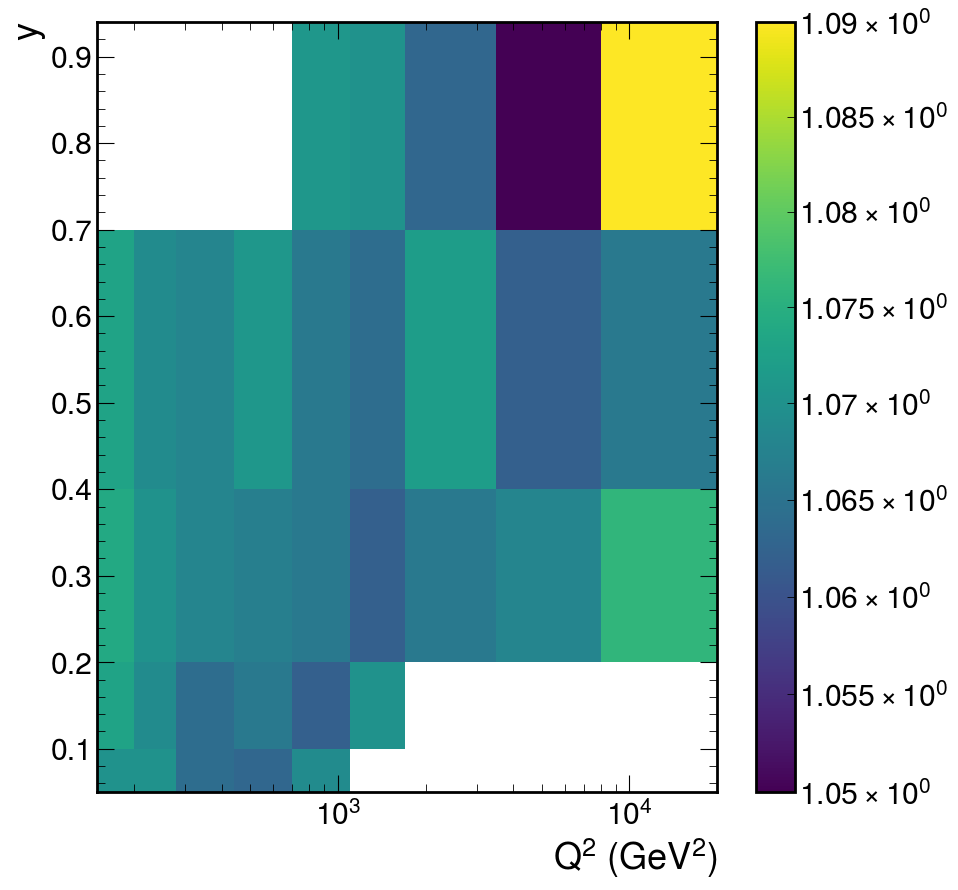

In [8]:
import matplotlib.colors as colors
plt.hist2d(table_38_df["Q2"], table_38_df["y"], bins=(paper_Q2, paper_y), weights=table_38_df["cQED"], norm=colors.LogNorm())
plt.xscale('log')
plt.xlabel("$Q^2~(GeV^2)$")
plt.ylabel("y")
plt.colorbar()

### Histogram plotting function

In [9]:
def make_hist(
    event_info,
    Q2_binning,
    y_binning,
    legend_names,
    colors,
    markers,
    use_unfolding = True,
    paper_empty_mask = None,
    apply_QED = True,
    paper_df = None,
    draw_bins = True,
    fill_markers = True,
    shift_x_percent = 0,
):
    # Multiplicative factors used in the paper
    luminosity = 136
    multiplication_factors = [10**0, 10**1, 10**2, 10**3, 10**3]
    
    hist_data = []
    hist_bin_centers = []
    # Making histograms for each y bin
    for i in range(len(y_binning)-1):
        y_mask = (event_info["y"]>=y_binning[i]) & (event_info["y"]<y_binning[i+1])
        y_bin_width = y_binning[i+1] - y_binning[i]

        hist_weight = event_info["weight"][y_mask]*multiplication_factors[i]/luminosity

        if use_unfolding:
            hist_weight = hist_weight*event_info["unfolded_weights"][y_mask]
        counts, bin_edges = np.histogram(
            event_info["Q2"][y_mask], weights = hist_weight, bins = Q2_binning)
        bin_centers = bin_edges[:-1]+ 0.5*(bin_edges[1:] - bin_edges[:-1])
        if np.any(counts):
            bin_widths = np.diff(paper_Q2)*y_bin_width

            # Grabbing the QED corrections from the table and applying them
            if apply_QED:
                QED_corrections = []
                counter = 0
                for center_Q2 in bin_centers:
                    df_y_mask = (paper_df["y"]>=y_binning[i]) & (paper_df["y"]<y_binning[i+1])
                    df_Q2 = paper_df["Q2"][df_y_mask]
                    
                    Q2_mask = (center_Q2>df_Q2)
                    cQED = paper_df["cQED"][df_y_mask][Q2_mask]
                    # If there's no corrections listed for this bin, then use 1. We'll mask this entry anyways with paper_empty_mask
                    if counter >= len(cQED):
                        QED_corrections.append(1)
                    else:
                        QED_corrections.append(cQED.tolist()[-1])
                        counter += 1
            normalized_counts = counts / bin_widths
            if apply_QED:
                normalized_counts = normalized_counts * QED_corrections
            if paper_empty_mask is not None:
                bin_centers = bin_centers[paper_empty_masks[i]]
                normalized_counts = normalized_counts[paper_empty_masks[i]]
        if fill_markers:
            plt.scatter(bin_centers + bin_centers*shift_x_percent, normalized_counts, label=legend_names[i], color=colors[i], marker=markers[i])
        else:
            plt.scatter(bin_centers + bin_centers*shift_x_percent, normalized_counts, label=legend_names[i], color=colors[i], marker=markers[i], facecolors='none')
        hist_data.append(normalized_counts)
        hist_bin_centers.append(bin_centers)
        if draw_bins:
            _, _, _, = plt.hist(bin_centers + bin_centers*shift_x_percent, weights = normalized_counts, bins=paper_Q2, color=colors[i], histtype='step')
    return hist_data, hist_bin_centers

Text(0.5, 1.0, ' Rapgap unfolded to H1')

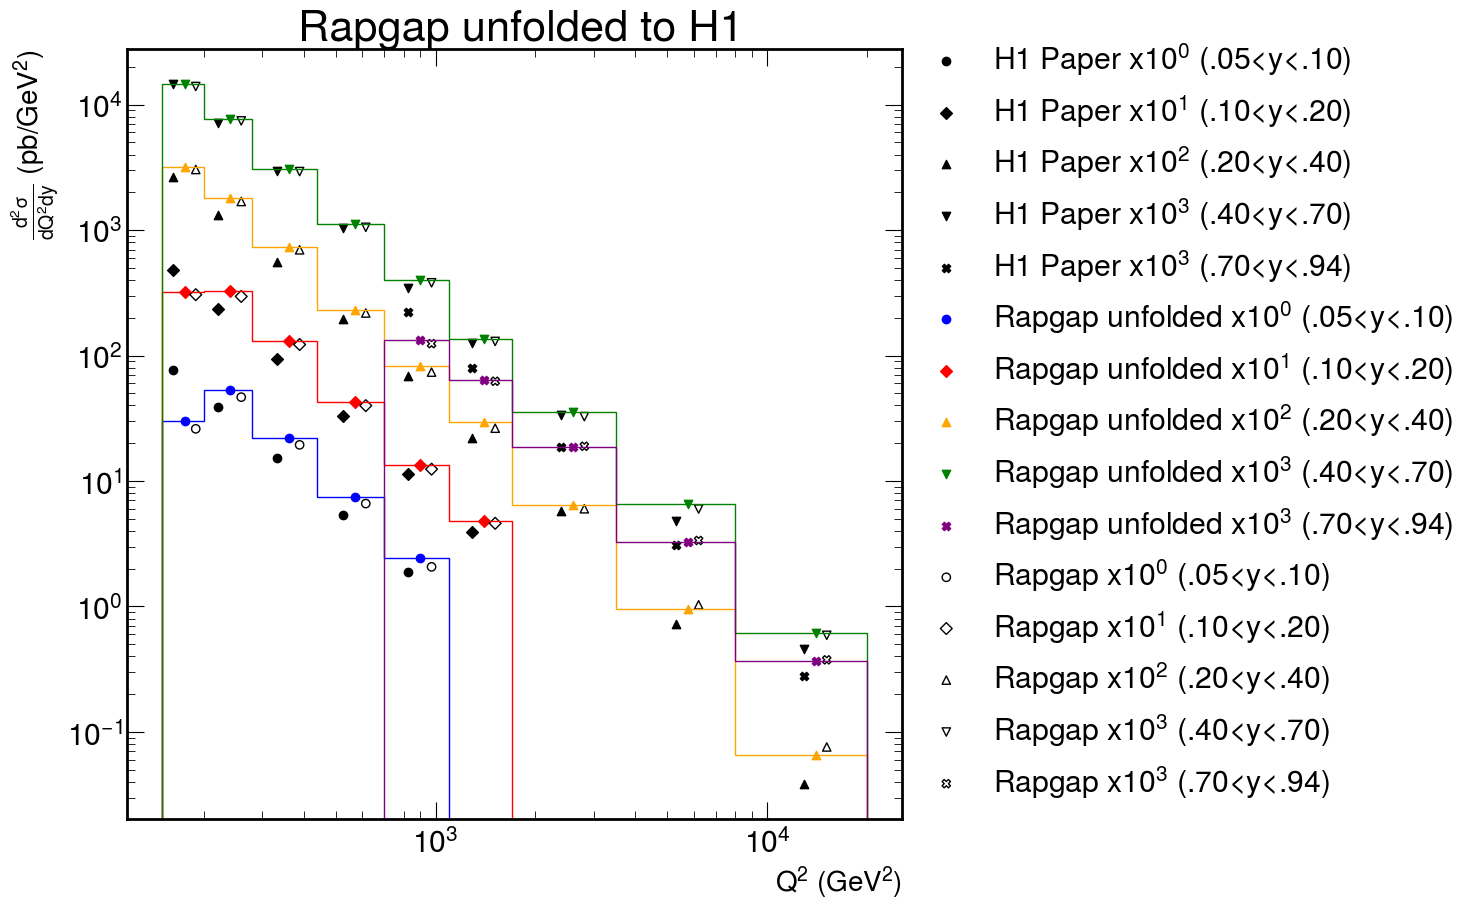

In [10]:
fig = plt.figure(figsize=(10, 10))
luminosity = 136

multiplication_factors = [10**0, 10**1, 10**2, 10**3, 10**3]


legend_names_H1 = ["H1 Paper $x 10^0$ (.05<y<.10)",
                   "H1 Paper $x 10^1$ (.10<y<.20)",
                   "H1 Paper $x 10^2$ (.20<y<.40)",
                   "H1 Paper $x 10^3$ (.40<y<.70)",
                   "H1 Paper $x 10^3$ (.70<y<.94)"]
colors = ['blue', 'red', 'orange', 'green', 'purple']
markers = ["o", "D", "^", "v", "X"]

paper_empty_masks = []
H1_paper_data = []
# Plotting the H1 data from the paper
for i in range(len(paper_y)-1):
    y_mask = (table_38_df["y"]>=paper_y[i]) & (table_38_df["y"]<paper_y[i+1])
    y_bin_width = paper_y[i+1] - paper_y[i]
    Q2_values = table_38_df["Q2"][y_mask]
    weights = table_38_df["dsigma"][y_mask]
    counts, bin_edges = np.histogram(
        Q2_values,
        weights= weights * multiplication_factors[i],
        bins=paper_Q2,
    )
    bin_centers = bin_edges[:-1]+ 0.5*(bin_edges[1:] - bin_edges[:-1])
    if np.any(counts):
        bin_widths = np.diff(paper_Q2)*y_bin_width
        QED_corrections = []
        counter = 0
        for center_Q2 in bin_centers:
            df_y_mask = (table_38_df["y"]>=paper_y[i]) & (table_38_df["y"]<paper_y[i+1])
            df_Q2 = table_38_df["Q2"][df_y_mask]
            
            Q2_mask = (center_Q2>df_Q2)
            cQED = table_38_df["cQED"][df_y_mask][Q2_mask]
            if counter >= len(cQED):
                QED_corrections.append(1)
            else:
                QED_corrections.append(cQED.tolist()[-1])
                counter += 1
        normalized_counts = counts / bin_widths
        normalized_counts = normalized_counts*QED_corrections
        plt.scatter(bin_centers-bin_centers*.08, normalized_counts, label=legend_names_H1[i], color='black', marker=markers[i])
        empty_mask = normalized_counts!=0
        paper_empty_masks.append(empty_mask)
        H1_paper_data.append(normalized_counts[empty_mask])


Rapgap_unfolded_legend_names = ["Rapgap unfolded $x 10^0$ (.05<y<.10)",
                                "Rapgap unfolded $x 10^1$ (.10<y<.20)",
                                "Rapgap unfolded $x 10^2$ (.20<y<.40)",
                                "Rapgap unfolded $x 10^3$ (.40<y<.70)",
                                "Rapgap unfolded $x 10^3$ (.70<y<.94)"]

MC_data, MC_bin_centers = make_hist(
    event_info,
    paper_Q2,
    paper_y,
    Rapgap_unfolded_legend_names,
    colors,
    markers,
    use_unfolding = True,
    paper_empty_mask = paper_empty_masks,
    apply_QED = True,
    paper_df = table_38_df,
)



Rapgap_nounfold_legend_names = ["Rapgap $x 10^0$ (.05<y<.10)",
                                "Rapgap $x 10^1$ (.10<y<.20)",
                                "Rapgap $x 10^2$ (.20<y<.40)",
                                "Rapgap $x 10^3$ (.40<y<.70)",
                                "Rapgap $x 10^3$ (.70<y<.94)"]
nounfold_colors = ['black', 'black', 'black', 'black', 'black']

MC_data_nounfolding, MC_bin_centers_nounfolding = make_hist(
    event_info,
    paper_Q2,
    paper_y,
    Rapgap_nounfold_legend_names,
    nounfold_colors,
    markers,
    use_unfolding = False,
    paper_empty_mask = paper_empty_masks,
    apply_QED = True,
    paper_df = table_38_df,
    draw_bins = False,
    fill_markers = False,
    shift_x_percent = .08,
)


plt.xscale('log')
plt.yscale('log')
plt.ylabel("$\\frac{d^2\sigma}{dQ^2dy}~(pb/GeV^2)$", fontsize=20)
plt.legend(bbox_to_anchor=(1.75, 1.05))

plt.xlabel("$Q^2~(GeV^2)$", fontsize=20)
plt.title(f" Rapgap unfolded to {data_name}")

Text(0.5, 1.0, ' Rapgap unfolded to H1')

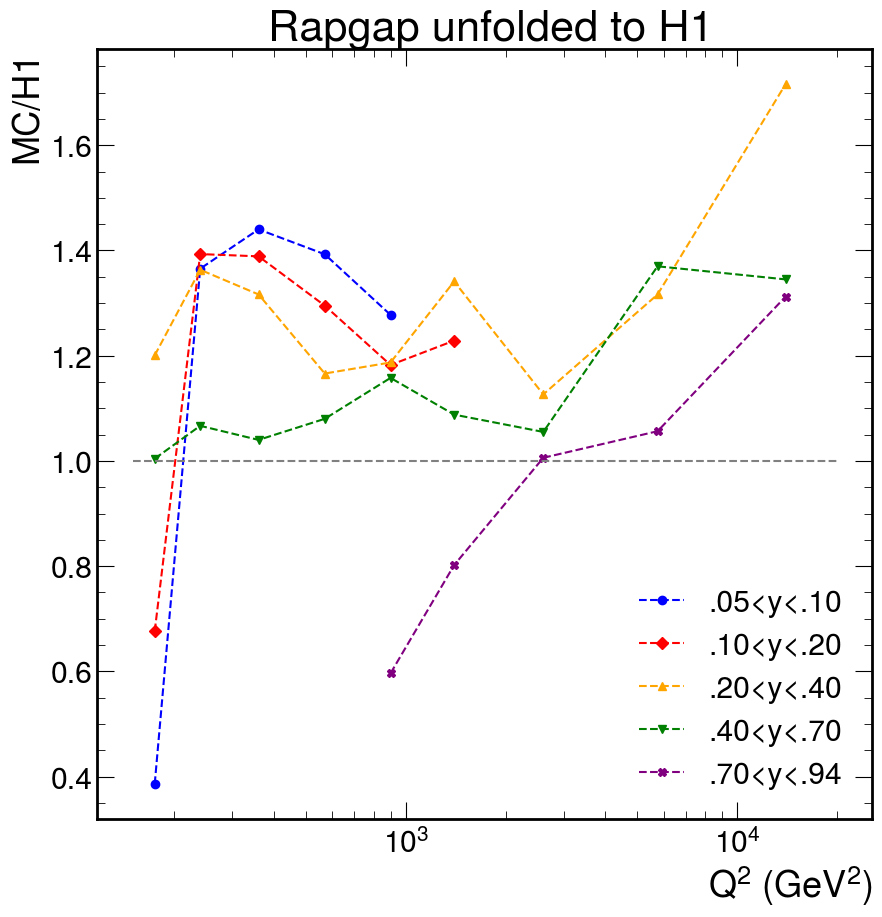

In [11]:
legend_names_ratio = [".05<y<.10",
                      ".10<y<.20",
                      ".20<y<.40",
                      ".40<y<.70",
                      ".70<y<.94"]
for i, (paper, MC) in enumerate(zip(H1_paper_data, MC_data)):
    zero_mask = paper!=0
    plt.plot(MC_bin_centers[i][zero_mask], np.array(MC[zero_mask])/np.array(paper[zero_mask]), label=legend_names_ratio[i], color=colors[i], marker=markers[i], linestyle='dashed')
plt.legend()
plt.xlabel("$Q^2~(GeV^2)$")
plt.ylabel("MC/H1")
plt.xscale('log')
plt.hlines(1, paper_Q2[0], paper_Q2[-1], color='grey', linestyle='dashed')
plt.title(f" Rapgap unfolded to {data_name}")

### Unfolding Rapgap to Djangoh (closure results)

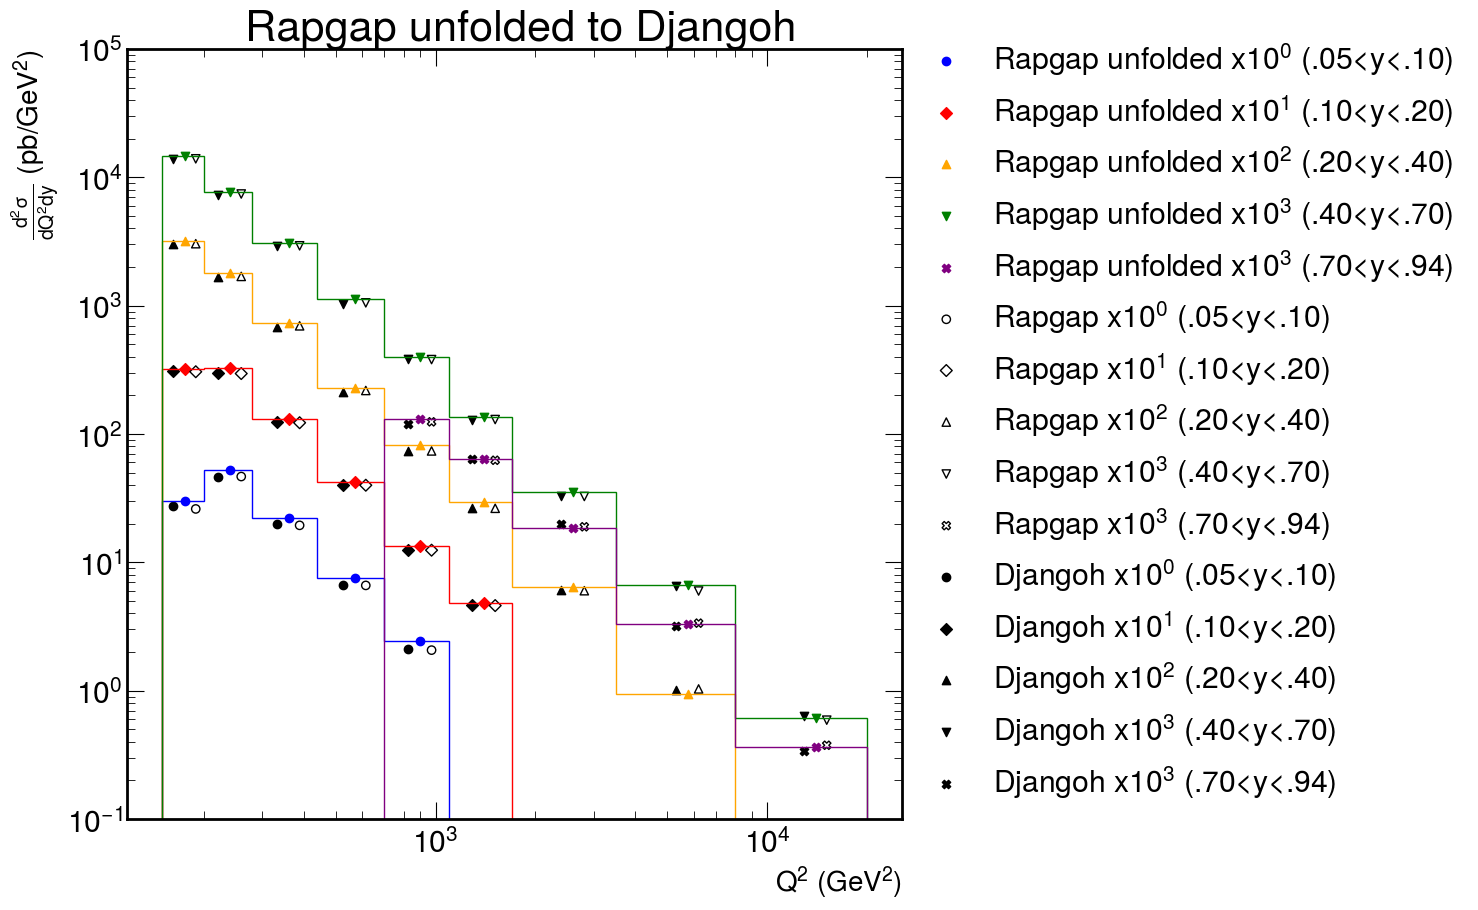

In [12]:
if plot_closure_results:
    fig = plt.figure(figsize=(10, 10))
    
    Rapgap_unfolded_legend_names = ["Rapgap unfolded $x 10^0$ (.05<y<.10)",
                                "Rapgap unfolded $x 10^1$ (.10<y<.20)",
                                "Rapgap unfolded $x 10^2$ (.20<y<.40)",
                                "Rapgap unfolded $x 10^3$ (.40<y<.70)",
                                "Rapgap unfolded $x 10^3$ (.70<y<.94)"]

    MC_data, MC_bin_centers = make_hist(
        event_info,
        paper_Q2,
        paper_y,
        Rapgap_unfolded_legend_names,
        colors,
        markers,
        use_unfolding = True,
        paper_empty_mask = paper_empty_masks,
        apply_QED = True,
        paper_df = table_38_df,
    )

    Rapgap_nounfold_legend_names = ["Rapgap $x 10^0$ (.05<y<.10)",
                                "Rapgap $x 10^1$ (.10<y<.20)",
                                "Rapgap $x 10^2$ (.20<y<.40)",
                                "Rapgap $x 10^3$ (.40<y<.70)",
                                "Rapgap $x 10^3$ (.70<y<.94)"]
    nounfold_colors = ['black', 'black', 'black', 'black', 'black']
    
    MC_data_nounfolding, MC_bin_centers_nounfolding = make_hist(
        event_info,
        paper_Q2,
        paper_y,
        Rapgap_nounfold_legend_names,
        nounfold_colors,
        markers,
        use_unfolding = False,
        paper_empty_mask = paper_empty_masks,
        apply_QED = True,
        paper_df = table_38_df,
        draw_bins = False,
        fill_markers = False,
        shift_x_percent = .08,
    )

    djangoh_legend_names = ["Djangoh $x 10^0$ (.05<y<.10)",
                            "Djangoh $x 10^1$ (.10<y<.20)",
                            "Djangoh $x 10^2$ (.20<y<.40)",
                            "Djangoh $x 10^3$ (.40<y<.70)",
                            "Djangoh $x 10^3$ (.70<y<.94)"]
    djangoh_data, djangoh_bin_centers = make_hist(
        djangoh_event_info,
        paper_Q2,
        paper_y,
        djangoh_legend_names,
        nounfold_colors,
        markers,
        use_unfolding = False,
        paper_empty_mask = paper_empty_masks,
        apply_QED = True,
        paper_df = table_38_df,
        draw_bins = False,
        fill_markers = True,
        shift_x_percent = -.08,
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("$\\frac{d^2\sigma}{dQ^2dy}~(pb/GeV^2)$", fontsize=20)
    plt.legend(bbox_to_anchor=(1.75, 1.05))
    
    plt.xlabel("$Q^2~(GeV^2)$", fontsize=20)
    plt.title(f" Rapgap unfolded to Djangoh")
    plt.ylim(0.1, 10**5)

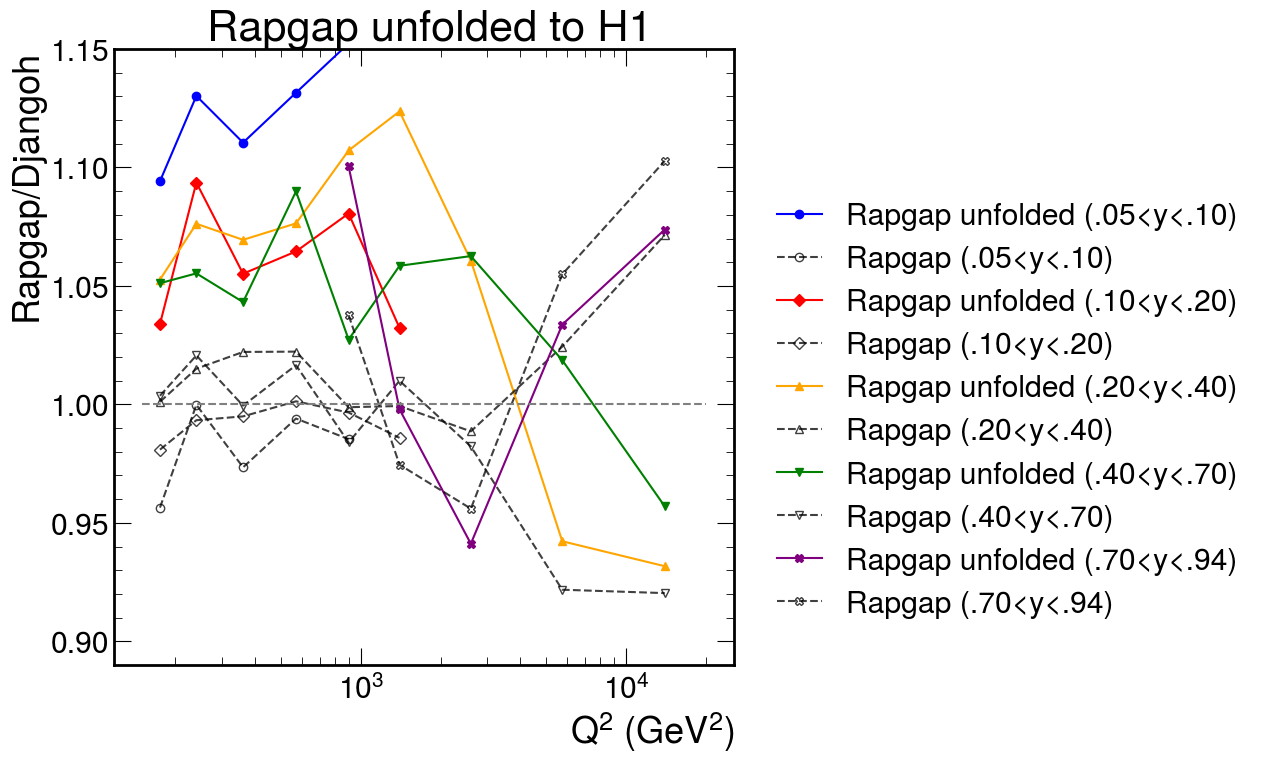

In [13]:
if plot_closure_results:
    fig = plt.figure(figsize=(8,8))
    legend_names_ratio = ["Rapgap unfolded (.05<y<.10)",
                          "Rapgap unfolded (.10<y<.20)",
                          "Rapgap unfolded (.20<y<.40)",
                          "Rapgap unfolded (.40<y<.70)",
                          "Rapgap unfolded (.70<y<.94)"]
    legend_names_ratio_nounfold = ["Rapgap (.05<y<.10)",
                          "Rapgap (.10<y<.20)",
                          "Rapgap (.20<y<.40)",
                          "Rapgap (.40<y<.70)",
                          "Rapgap (.70<y<.94)"]
    for i, (djangoh, MC, MC_nounfold) in enumerate(zip(djangoh_data, MC_data, MC_data_nounfolding)):
        zero_mask = djangoh!=0
        plt.plot(MC_bin_centers[i][zero_mask], np.array(MC[zero_mask])/np.array(djangoh[zero_mask]), label=legend_names_ratio[i], color=colors[i], marker=markers[i], linestyle='solid')
        plt.plot(MC_bin_centers[i][zero_mask], np.array(MC_nounfold[zero_mask])/np.array(djangoh[zero_mask]), label=legend_names_ratio_nounfold[i], alpha=.75, color='black', marker=markers[i], markerfacecolor='none', linestyle='dashed')
    plt.legend(bbox_to_anchor=(1.02, .8))
    plt.xlabel("$Q^2~(GeV^2)$")
    plt.ylabel("Rapgap/Djangoh")
    plt.xscale('log')
    plt.hlines(1, paper_Q2[0], paper_Q2[-1], color='grey', linestyle='dashed')
    plt.title(f" Rapgap unfolded to {data_name}")
    plt.ylim(0.89, 1.15)